<a href="https://colab.research.google.com/github/ErlantzCalvo/Parkinson_Detection/blob/master/Parkinson_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%cd drive/My\ Drive
%cd 'Colab Notebooks/'
%cd 'datasets/ParkinsonDisease/'

/content/drive/My Drive
/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks/datasets/ParkinsonDisease


In [3]:
!pip install tpot

     |████████████████████████████████| 92kB 2.8MB/s 
     |████████████████████████████████| 163kB 10.5MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp36-none-any.whl size=11956 sha256=36774401a8d30132fadc82ab35282f38abc25ea6d30801b1b918a7254b93cc58
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit


In [79]:
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from tpot import TPOTClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.tree import export_graphviz
from sklearn import svm
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix

# Data explanation
The data .csv has the next format: \\
  X ; Y; Z; Pressure; GripAngle; Timestamp; Test ID

----------------
Test ID: \\
0: Static Spiral Test ( Draw on the given spiral pattern) \\
1: Dynamic Spiral Test ( Spiral pattern will blink in a certain time, so subjects need to continue on their draw) \\
2: Circular Motion Test (Subjectd draw circles around the red point)

# Sources and explanation
Isenkul, Muhammed & Sakar, Betul & Kursun, O.. (2014). Improved Spiral Test Using Digitized Graphics Tablet for Monitoring Parkinson’s Disease. 10.13140/RG.2.1.1898.6005. 

Sakar, Betul & Isenkul, Muhammed & Sakar, C. Okan & Sertbaş, Ahmet & Gurgen, F. & Delil, Sakir & Apaydin, Hulya & Kursun, Olcay. (2013). Collection and Analysis of a Parkinson Speech Dataset With Multiple Types of Sound Recordings. Biomedical and Health Informatics, IEEE Journal of. 17. 828-834. 10.1109/JBHI.2013.2245674. 

# Dataset
https://archive.ics.uci.edu/ml/datasets/Parkinson+Disease+Spiral+Drawings+Using+Digitized+Graphics+Tablet


# Loading data
We've got 2 different datasets:
  

*   **Control**: People who did the tests without having the Parkinson disease. 
*   **Parkinson**: People who did the tests having the Parkinson disease. 

*Note:* The parkinson dataset is splitted in two different paths, so we'll load both of them and then mix them.

In [5]:
CONTROL_DATASET_PATH = 'hw_dataset/control'
PARKINSON_DATASET_PATH = 'hw_dataset/parkinson'
PARKINSON_DATASET_PATH_2 = 'new_dataset/parkinson'


def loadDatasets(control_path, parkinson_path):
  COLUMN_NAMES = ['X', 'Y', 'Z', 'Pressure', 'GripAngle', 'Timestamp', 'Test ID','UserId']
  userid = 0
  #Load Control dataset
  control_files = os.listdir(control_path)
  df_control = pd.DataFrame(columns=COLUMN_NAMES)
  #df_control.columns = COLUMN_NAMES
  for i in tqdm(range(len(control_files)), desc= 'Control files: ', unit=' files'):
    new_user_path = os.path.join(control_path, control_files[i])
    new_user = pd.read_csv(new_user_path, header=None,  sep=';', names=COLUMN_NAMES)
    new_user['UserId'] = userid
    df_control = df_control.append(new_user)
    userid +=1


  #Load parkinson dataset
  parkinson_files = os.listdir(parkinson_path)
  df_parkinson = pd.DataFrame(columns=COLUMN_NAMES)

  for j in tqdm(range(len(parkinson_files)), desc= 'Parkinson files: ', unit=' files'):
    new_user_path = os.path.join(parkinson_path, parkinson_files[j])  
    new_user = pd.read_csv(new_user_path, header=None,  sep=';',names=COLUMN_NAMES)
    new_user['UserId'] = userid
    df_parkinson = df_parkinson.append(new_user)
    userid +=1

  parkinson_files =  os.listdir(PARKINSON_DATASET_PATH_2)
  for k in tqdm(range(len(parkinson_files)), desc= 'Parkinson files: ', unit=' files'):
    new_user_path = os.path.join(PARKINSON_DATASET_PATH_2, parkinson_files[i])  
    new_user = pd.read_csv(new_user_path, header=None,  sep=';')
    new_user['UserId'] = userid
    df_parkinson = df_parkinson.append(new_user)
    userid +=1


  return df_parkinson, df_control
df_parkinson, df_control= loadDatasets(CONTROL_DATASET_PATH, PARKINSON_DATASET_PATH)


Parkinson files: 100%|██████████| 37/37 [00:02<00:00, 13.14 files/s]


# Getting variable variation
We extract how much does a certain variable change during all the dataset

In [6]:
def getSubjectDeltas(subjectData):
  subjectGripAngleDelta = 0
  subjectPressureDelta = 0
  subjectCoordDelta = 0
  for i in range(len(subjectData)-1):
    subjectGripAngleDelta += abs(subjectData['GripAngle'].iloc[i+1] - subjectData['GripAngle'].iloc[i])
    
    subjectPressureDelta += abs(subjectData['Pressure'].iloc[i+1] - subjectData['Pressure'].iloc[i])
    subjectPressureDelta += abs(subjectData['Z'].iloc[i+1] - subjectData['Z'].iloc[i])

    subjectCoordDelta+= abs(subjectData['X'].iloc[i+1] - subjectData['X'].iloc[i]) + abs(subjectData['Y'].iloc[i+1] - subjectData['Y'].iloc[i]) + abs(subjectData['Z'].iloc[i+1] - subjectData['Z'].iloc[i])

  return subjectGripAngleDelta, subjectPressureDelta, subjectCoordDelta


We prepare the final dataset with the model will be trained and tested. So we will do some feature extraction and join the control dataset and the parkinson dataset.





In [60]:
def extractFeatures(dataset, subjects, isParkinson):
  NEW_COLUMNS = ['UserID', 'CoordinatesDelta','GripAngleVariance', 'GripAngleStd', 'GripAngleDelta', 'PressureVariance', 'PressureStd', 'PressureDelta', 'Duration', 'Test ID', 'Parkinson']
  df_polished = pd.DataFrame(columns=NEW_COLUMNS)

  for i in range(3):
    for j in tqdm(range(len(subjects)), desc=f'Test : '):
      df_subject = dataset[(dataset['Test ID'] ==i) & (dataset['UserId']==subjects[j])]
      
      if len(df_subject)>0:
        #insert new values to the dataset
        angleVariance = df_subject['GripAngle'].var()
        angleStDeviation = df_subject['GripAngle'].std()

        pressureVariance =  df_subject['Pressure'].var()
        pressureStDeviation = df_subject['Pressure'].std()

        startTime = df_subject['Timestamp'].iloc[0]
        endTime = df_subject['Timestamp'].iloc[-1]
        duration = endTime - startTime

        gripAngleDelta, pressureDelta, coordDelta = getSubjectDeltas(df_subject)
        gripAngleDelta = gripAngleDelta / duration
        pressureeDelta = pressureDelta / duration
        coordDelta = coordDelta / duration

        df_polished = df_polished.append({'UserID': int(subjects[j]), 'CoordinatesDelta' : coordDelta, 'GripAngleVariance' : angleVariance, 'GripAngleStd' : angleStDeviation, 'GripAngleDelta' : gripAngleDelta, 'PressureVariance' : pressureVariance, 'PressureStd' : pressureStDeviation, 'PressureDelta' : pressureDelta, 'Duration' : duration, 'Test ID' : i, 'Parkinson' : isParkinson},ignore_index = True)
        df_polished[['UserID', 'Duration', 'Test ID', 'Parkinson']] =  df_polished[['UserID', 'Duration', 'Test ID', 'Parkinson']].astype(int)
  return df_polished

def prepareDataset(controlDataset, parkinsonDataset):
  control_usersId = controlDataset['UserId'].unique()
  control_polished = extractFeatures(controlDataset, control_usersId, 0)

  parkinson_usersId = parkinsonDataset['UserId'].unique()
  parkinson_polished = extractFeatures(parkinsonDataset, parkinson_usersId, 1)

  frames = [control_polished, parkinson_polished]
  final_dataset = pd.concat(frames)
  oneHot = pd.get_dummies(final_dataset['Test ID'], prefix='Test_ID')
  final_dataset = final_dataset.join(oneHot)  
  final_dataset = final_dataset.drop('Test ID', axis=1)
  
  return final_dataset
final_dataset = prepareDataset(df_control, df_parkinson)
final_dataset

Test : 100%|██████████| 62/62 [00:06<00:00,  8.98it/s]


,UserID,CoordinatesDelta,GripAngleVariance,GripAngleStd,GripAngleDelta,PressureVariance,PressureStd,PressureDelta,Duration,Parkinson,Test_ID_0,Test_ID_1,Test_ID_2
0,0,0.331642,23503.860477,153.309688,1.625958,5512.006177,74.242886,10457.0,18137,0,1,0,0
0,0,0.331642,23503.860477,153.309688,1.625958,5512.006177,74.242886,10457.0,18137,0,1,0,0
0,15,0.202528,32133.589852,179.258444,0.692450,27831.318457,166.827211,13158.0,23814,1,1,0,0
0,15,0.202528,32133.589852,179.258444,0.692450,27831.318457,166.827211,13158.0,23814,1,1,0,0
1,1,0.304067,20211.096496,142.165736,1.115038,3224.260485,56.782572,11295.0,21219,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,35,0.327847,4711.990537,68.643940,1.130587,36321.531088,190.582085,20620.0,38396,1,0,0,1
69,36,0.514275,258.257857,16.070403,0.169978,21991.916184,148.296717,8490.0,13590,1,0,0,1
70,37,0.595638,9071.367686,95.243728,1.347038,0.000000,0.000000,6222.0,11967,1,0,0,1
71,38,0.439879,2236.877389,47.295638,1.254485,0.000000,0.000000,5970.0,14213,1,0,0,1


# Data visualization

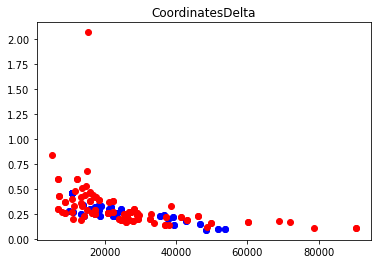

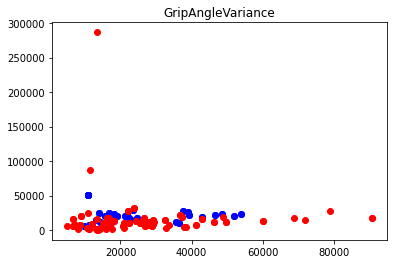

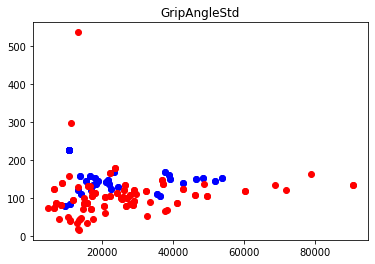

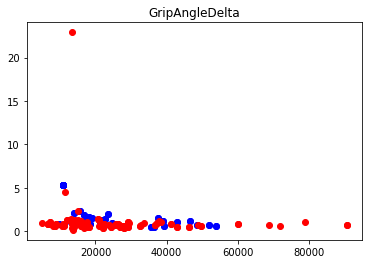

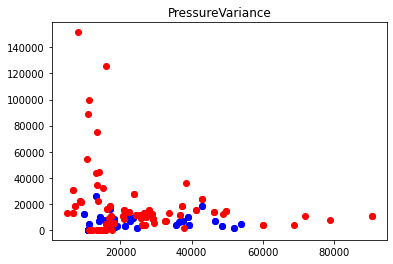

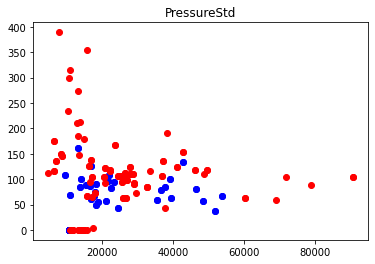

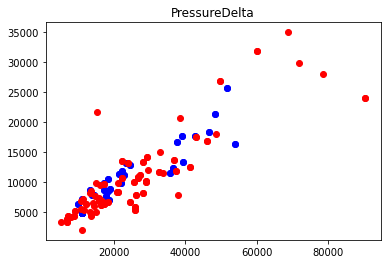

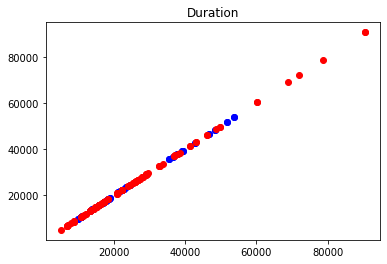

In [61]:
control_data = final_dataset[final_dataset['Parkinson']==0].drop(['UserID', 'Parkinson', 'Test_ID_0','Test_ID_1','Test_ID_2'],1)
parkinson_data = final_dataset[final_dataset['Parkinson']==1].drop(['UserID', 'Parkinson', 'Test_ID_0','Test_ID_1','Test_ID_2'],1)

control_duration = control_data['Duration']
parkinson_duration = parkinson_data['Duration']

for col in control_data.columns:
  plt.figure()
  control_col = control_data[col]
  parkinson_col = parkinson_data[col]
  plt.plot(control_duration, control_col, 'bo', parkinson_duration, parkinson_col, 'ro')
  plt.title(col)
  plt.show()

# Prepare the training and test datasets



In [62]:
trainX = final_dataset[0::2]
trainY = trainX['Parkinson']
trainX = trainX.drop(['UserID','Parkinson', 'Test_ID_0', 'Test_ID_1', 'Test_ID_2'],1)

testX = final_dataset[1::2]
testY = testX['Parkinson']
testX = testX.drop(['UserID','Parkinson', 'Test_ID_0', 'Test_ID_1', 'Test_ID_2'],1)

In [63]:
lr = LogisticRegression()
lr.fit(trainX, trainY)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [64]:
prediction = lr.predict(testX)
print(f'Accuracy: {accuracy_score(testY, prediction)}')
print(f'Balanced Accuracy: {balanced_accuracy_score(testY, prediction)}')
confusion_matrix(testY, prediction)

Accuracy: 0.7717391304347826
Balanced Accuracy: 0.7648648648648648


array([[27, 10],
       [11, 44]])

In [68]:
tpot = TPOTClassifier(generations=10, verbosity=2)
tpot.fit(trainX, trainY)


Generation 1 - Current best internal CV score: 0.8602339181286549
Generation 2 - Current best internal CV score: 0.9017543859649123
Generation 3 - Current best internal CV score: 0.9017543859649123
Generation 4 - Current best internal CV score: 0.9017543859649123
Generation 5 - Current best internal CV score: 0.9017543859649123
Generation 6 - Current best internal CV score: 0.9017543859649123
Generation 7 - Current best internal CV score: 0.9017543859649123
Generation 8 - Current best internal CV score: 0.9017543859649123
Generation 9 - Current best internal CV score: 0.9017543859649123

Best pipeline: ExtraTreesClassifier(VarianceThreshold(RandomForestClassifier(RobustScaler(MaxAbsScaler(RandomForestClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), bootstrap=True, criterion=entropy, max_features=0.1, min_samples_leaf=2, min_samples_split=5, n_estimators=100))), bootstrap=False, criterion=entropy, max_features=0.15000000000000002, min_samples_leaf=3, min_samples_s

TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=10,
               log_file=<ipykernel.iostream.OutStream object at 0x7fadc04d2a90>,
               max_eval_time_mins=5, max_time_mins=None, memory=None,
               mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=100,
               random_state=None, scoring=None, subsample=1.0, template=None,
               use_dask=False, verbosity=2, warm_start=False)

In [65]:
rf = RandomForestClassifier()
rf.fit(trainX, trainY)
prediction = rf.predict(testX)
print(f'Accuracy: {accuracy_score(testY, prediction)}')
print(f'Balanced Accuracy: {balanced_accuracy_score(testY, prediction)}')
confusion_matrix(testY, prediction)

Accuracy: 0.9782608695652174
Balanced Accuracy: 0.9818181818181818


array([[37,  0],
       [ 2, 53]])

In [66]:
svc = svm.SVC()
svc.fit(trainX, trainY)
prediction = svc.predict(testX)
print(f'Accuracy: {accuracy_score(testY, prediction)}')
print(f'Balanced Accuracy: {balanced_accuracy_score(testY, prediction)}')
confusion_matrix(testY, prediction)

Accuracy: 0.8804347826086957
Balanced Accuracy: 0.8646191646191645


array([[29,  8],
       [ 3, 52]])

In [69]:
prediction = tpot.predict(testX)
print(f'Accuracy: {accuracy_score(testY, prediction)}')
print(f'Balanced Accuracy: {balanced_accuracy_score(testY, prediction)}')
confusion_matrix(testY, prediction)

Accuracy: 0.9891304347826086
Balanced Accuracy: 0.990909090909091


array([[37,  0],
       [ 1, 54]])

In [72]:
cross_val_Y = final_dataset['Parkinson']
cross_val_X = final_dataset.drop(['UserID', 'Parkinson', 'Test_ID_0', 'Test_ID_1', 'Test_ID_2'],1)

lr_score = cross_val_score(lr, cross_val_X, cross_val_Y, cv = 73)
print(f'Logistic regression: {np.mean(lr_score)}')
svc_score = cross_val_score(svc, cross_val_X, cross_val_Y, cv = 73)
print(f'Support Vector Machine: {np.mean(svc_score)}')
rf_score = cross_val_score(rf, cross_val_X, cross_val_Y, cv = 73)
print(f'Random Forest: {np.mean(rf_score)}')
tpot_score = cross_val_score(tpot.fitted_pipeline_, cross_val_X, cross_val_Y, cv = 73)
print(f'TPOT: {np.mean(tpot_score)}')

Logistic regression: 0.7351598173515982
Support Vector Machine: 0.8835616438356164
Random Forest: 0.9657534246575342
TPOT: 0.9931506849315068


In [81]:
X_train, X_test, y_train, y_test = train_test_split(cross_val_X, cross_val_Y, stratify= cross_val_Y, test_size=0.25)

lr_score = cross_val_score(lr, cross_val_X, cross_val_Y, cv = 73)
print(f'Logistic regression: {np.mean(lr_score)}')
svc_score = cross_val_score(svc, cross_val_X, cross_val_Y, cv = 73)
print(f'Support Vector Machine: {np.mean(svc_score)}')
rf_score = cross_val_score(rf, cross_val_X, cross_val_Y, cv = 73)
print(f'Random Forest: {np.mean(rf_score)}')
tpot_score = cross_val_score(tpot.fitted_pipeline_, cross_val_X, cross_val_Y, cv = 73)
print(f'TPOT: {np.mean(tpot_score)}')



Logistic regression: 0.7351598173515982
Support Vector Machine: 0.8835616438356164
Random Forest: 0.958904109589041
TPOT: 0.9931506849315068


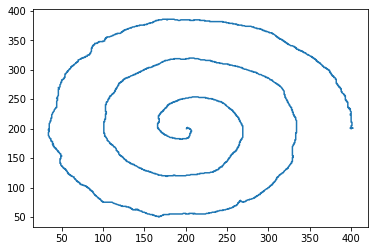

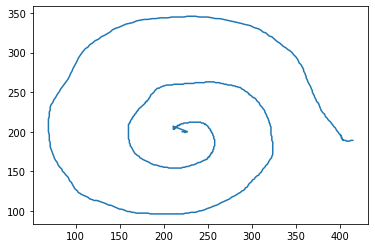

In [ ]:
uid = 2
x_draw = df_control[(df_control['UserId']==uid) & (df_control['Test ID']==1)]
y_draw = x_draw['Y'].to_list()
x_draw = x_draw['X'].to_list()
plt.plot(x_draw, y_draw)
plt.show()

x_draw_p = df_parkinson[(df_parkinson['UserId']==(uid+15)) & (df_parkinson['Test ID']==1)]
y_draw_p = x_draw_p['Y'].to_list()
x_draw_p = x_draw_p['X'].to_list()
plt.plot(x_draw_p, y_draw_p)
plt.show()

control: 1170.0  Prakinson: 1130.0
